In [1]:
import numpy as np    # 선형 대수 지원 라이브러리
import pandas as pd   # 데이터 처리, CSV 파일 I/O(예: pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2

In [2]:
labels = ['angry','disgust','fear','happy','neutral','sad','surprise']
img_size = 96
def get_training_data(data_dir):  # 훈련 데이터를 가져오는 함수
    data = []   # 이미지 데이터를 저장할 리스트 초기화
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)  # 레이블의 클래스 번호
         # 'label'이라는 특정 레이블이 'labels' 리스트에서 몇번째 위치에 있는가?
                                         
        for img in os.listdir(path):   # 해당 경로 내 이미지
            try:
                img_arr = cv2.imread(os.path.join(path, img),cv2.IMREAD_GRAYSCALE) # 이미지 흑백
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # 원하는 크기로 이미지 크기 변경
                normalized_arr = resized_arr.astype(np.float32)/255.0
                data.append([normalized_arr, class_num])  # 조정된 이미지, 클래스 번호를 데이터 리스트에 추가
            except Exception as e:  # 예외처리
                print(e)
    return data  # 처리된 데이터 리스트 반환

In [3]:
train = get_training_data('./archive/train')
test = get_training_data('./archive/test')

In [4]:
trainX = []
trainY = []

x_train = []  # 훈련 데이터의 이미지를 저장할 리스트
y_train = []  # 훈련 데이터의 레이블을 저장할 리스트

x_val = []
y_val = []

x_test = []  # 테스트 데이터의 이미지를 저장할 리스트
y_test = []  # 테스트 데이터의 레이블을 저장할 리스트


for feature, label in train:
    trainX.append(feature)
    trainY.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

x_train,x_val,y_train,y_val = train_test_split(trainX,trainY,test_size=0.2) 



In [5]:
x_train = np.array(x_train)
x_val = np.array(x_val) 
x_test = np.array(x_test)

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [6]:
# 과적합을 방지하고 데이터 세트의 불균형을 처리하기 위한 데이터 확대

datagen = ImageDataGenerator(
    featurewise_center=True,               # 데이터셋의 입력 평균을 0으로 설정
    samplewise_center=False,               # 각 샘플의 평균을 0으로 설정하지 않음
    featurewise_std_normalization=True,    # 데이터셋의 표준편차를 사용하여 입력을 정규화
    samplewise_std_normalization=False,    # 각 입력을 표준편차로 정규화하지 않음
    rotation_range=20,                     # 회전 범위 (0-20도)
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,                  # 수평 뒤집기
    vertical_flip=True,                    # 수직 뒤집기
    brightness_range=[0.8, 1.2],           # 밝기 조절
    fill_mode='nearest')
datagen.fit(x_train)

In [7]:
model = Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (img_size,img_size,1)))
model.add(BatchNormalization())  # 배치 정규화: 데이터 분포를 안정화하여 학습 과정을 가속화하고 성능을 향상
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))  # 최대 풀링: 이미지의 크기를 줄여 계산량을 감소시키고 중요한 특징을 추출

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))  # 드롭아웃: 과적합을 방지하기 위해 일부 뉴런을 랜덤하게 비활성화하여 모델을 일반화
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())  # 다차원 배열을 1차원으로 변환
model.add(Dense(units = 128 , activation = 'relu'))  # 완전 연결(Dense) 레이어
model.add(Dropout(0.2))
model.add(Dense(units=len(labels), activation='softmax'))  # 출력 레이어, 이진 분류를 위한 시그모이드 활성화 함수

model.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,162,823 (8.25 MB)

 Trainable params: 2,160,839 (8.24 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [8]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.5, min_lr=0.000001)

In [9]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 64), validation_data = datagen.flow(x_val, y_val) ,epochs = 50 ,callbacks = [learning_rate_reduction])

Epoch 1/50


c:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 289s 795ms/step - accuracy: 0.2189 - loss: 2.2803 - val_accuracy: 0.2569 - val_loss: 5.4049 - learning_rate: 0.0010
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 277s 770ms/step - accuracy: 0.2490 - loss: 1.8711 - val_accuracy: 0.1755 - val_loss: 2.1084 - learning_rate: 0.0010
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 248s 690ms/step - accuracy: 0.2498 - loss: 1.8432 - val_accuracy: 0.2577 - val_loss: 1.8208 - learning_rate: 0.0010
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 241s 670ms/step - accuracy: 0.2465 - loss: 1.8320 - val_accuracy: 0.2577 - val_loss: 1.8159 - learning_rate: 0.0010
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 245s 682ms/step - accuracy: 0.2504 - loss: 1.8224 - val_accuracy: 0.2577 - val_loss: 1.8122 - learning_rate: 0.0010
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.2493 - loss: 1.8187
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
359/359 ━━━━━━━━━━━━━━━━━━━━ 248s 689ms/step - accuracy: 0.2493 - l

In [15]:
pip install flask flask-socketio keras opencv-python


   ---------------------------------------- 0.0/76.2 kB ? eta -:--:--
   ---------------------------------------- 76.2/76.2 kB 4.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/57.7 kB ? eta -:--:--
   ---------------------------------------- 57.7/57.7 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [14]:
# 모델 훈련 코드 이후에 모델 저장
model.save('emotion_model.h5')

In [15]:
# 예측 수행
predictions = model.predict(x_val)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_val

180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step


In [16]:
# 각 감정별 예측 정확도 출력
report = classification_report(true_classes, predicted_classes, target_names=labels)
print(report)

              precision    recall  f1-score   support

       angry       0.60      0.55      0.57       812
     disgust       0.68      0.46      0.55        82
        fear       0.53      0.41      0.46       797
       happy       0.85      0.87      0.86      1457
     neutral       0.57      0.69      0.63       988
         sad       0.52      0.52      0.52       992
    surprise       0.77      0.80      0.79       614

    accuracy                           0.66      5742
   macro avg       0.65      0.62      0.63      5742
weighted avg       0.65      0.66      0.65      5742



In [13]:
# 혼동 행렬 출력
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)

[[ 454    5   60   56   94  147   15]
 [  28   27   13    1    5    8    2]
 [ 113    3  317   35  101  201   76]
 [  28    0   20 1244   69   41   23]
 [  52    0   40   91  630  174   13]
 [  80    1   88   37  174  546    9]
 [  24    0   65   43   26   14  449]]


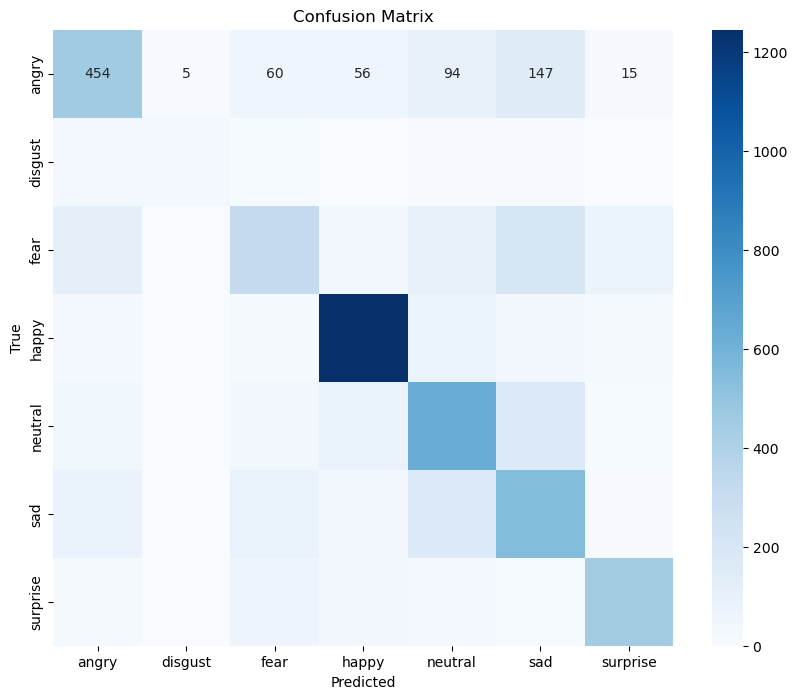

In [14]:
# 혼동 행렬을 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()